# Hopfield networks

Hopfield networks were [first imagined](https://www.pnas.org/content/pnas/79/8/2554.full.pdf) to be dynamical systems of coupled Ising spins, where a particular encoding scheme is used to set inter-spin connection strengths, such that any system state vector can be made to be a stable state of the system. Hopfield networks are a mathematical model of **memory**.

Let the state vector of the system is the set of spins $x_i \in \{-1, 1\}$ for $i=1,...,d$. The strength of connections between spins $i$ and $j$ is $W_{ij}$. The system evolves under the following dynamics. At some rate, spins flip according to the following rule:
- $x_i \rightarrow 1$ if $\sum_{i \neq j} W_{ij} x_j > U_i$
- $x_i \rightarrow 0$ if $\sum_{i \neq j} W_{ij} x_j < U_i$

until an equilibrium is reached. We usually set $U_i=0\ \forall\ i$.

If we configure $W_{ij}$ in a particular way, we can encode any arbitrary state vector $x$ to be an equilibrium of the dynamical system. Indeed, we can even attempt to store a **collection** of $N$ state vectors $x^s$ for $s=1,...,N$ as equilibria of the spin system, by encoding the collection of state vectors in the interaction strengths of the spins. We use the encoding rule
$$W_{ij} = \sum_{s=1}^N x_i^s x_j^s$$
i.e. a sum of outer products of each of the state vectors we wish to encode.

We then take some arbitrary state vector $\xi$ and allow this vector to evolve under the dynamics of the system (where the dimensions of $\xi$ can be updated **synchronously** or **asynchronously**). A synchronous update rule corresponds to all  spins/neurons of the system being updated at the same time using a centralised clock; such an update rule is
$$\xi^{t+1} = sgn(W \xi^t - U).$$
Synchronous update rules are often thought of as unrealistic biological models (and are also not great in machine learning because we often want to leverage large parallelism). An asynchronous update rule corresponds to applying the previous equation, but for only one component of $\xi$ at a time, until convergence is reached and $\xi^{t+1} = \xi^t$. This asynchronous update rule corresponds to hamiltonian dynamics with energy
$$E=-\frac{1}{2} \xi^T W \xi + \xi^T U.$$

See also:
- https://ml-jku.github.io/hopfield-layers/
- https://en.wikipedia.org/wiki/Hopfield_network 

## Hopfield network on a single image

We want to encode a single state vector as the equilibrium of the spin system, which will represent a binarized image of Homer Simpson.

In [59]:
import numpy as np
from scipy.sparse import coo_matrix

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('../resources/simpsons/homer.jpg')

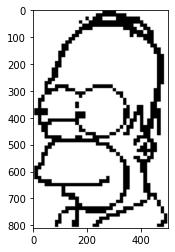

In [3]:
plt.imshow(img);

Here he is!

Use custom threshold to binarize the image and resize

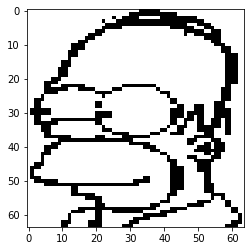

In [48]:
thresh = 118
fn = lambda x : 255 if x > thresh else 0
bw = img.convert('L').point(fn, mode='1')

size=64
r = bw.resize((size, size), Image.ANTIALIAS)

homer = 2*np.bitwise_not(np.array(r)) - 1

plt.imshow(homer, cmap='Greys');

In [49]:
homer.min(), homer.max()

(-1, 1)

In [50]:
homer.shape

(64, 64)

Encode Homer as a vector $x$ in the interaction strengths of the spins $W$.

In [21]:
homer_vec = homer.reshape((size*size, 1))

In [22]:
W = homer_vec.dot(homer_vec.transpose())

Now take an initial state $\xi$ as some corrupted image of Homer (we could start with any vector because $x$ will turn out to be a global attractor).

In [32]:
initial_state = homer_vec.copy()
initial_state[int(size*size/2):] = 1

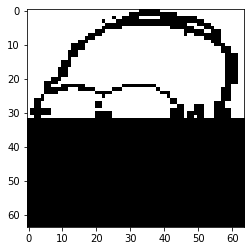

In [33]:
plt.imshow(initial_state.reshape((size, size)), cmap='Greys')

We can evolve the image in one shot to the system equilibrium.

In [42]:
final_state = np.sign(W.dot(initial_state))

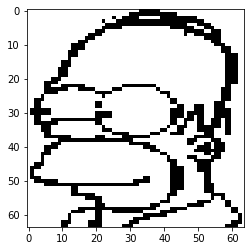

In [44]:
plt.imshow(final_state.reshape((size,size)), cmap='Greys');

We got the same image.

## Hopfield network on multiple images

Things get interesting if we want to encode $N$ images.

In [45]:
from pathlib import Path

In [46]:
simpsons = list(Path('../resources/simpsons/').glob('*'))
simpsons = {f.stem: f for f in simpsons}

In [47]:
simpsons

{'bart': PosixPath('../resources/simpsons/bart.jpg'),
 'homer': PosixPath('../resources/simpsons/homer.jpg'),
 'lisa': PosixPath('../resources/simpsons/lisa.jpg'),
 'marge': PosixPath('../resources/simpsons/marge.jpg')}

In [51]:
def threshold_square_vectorize(file, thresh, size):
    img = Image.open(file)
    fn = lambda x : 255 if x > thresh else 0
    bw = img.convert('L').point(fn, mode='1')
    r = bw.resize((size, size), Image.ANTIALIAS)
    return 2*np.bitwise_not(np.array(r)) - 1


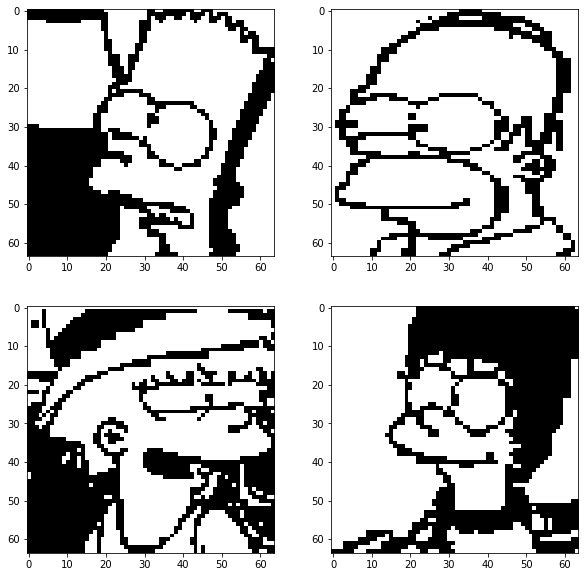

In [54]:
thresh = {'bart': 200, 'homer': 118, 'lisa': 200, 'marge': 170}
state_vectors = {}
size = 64

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()

for i, simpson in enumerate(simpsons):
    v = threshold_square_vectorize(simpsons[simpson], thresh[simpson], size)
    state_vectors[simpson] = v.reshape((size*size, 1))
    
    ax = axs[i]
    ax.imshow(v, cmap='Greys')

In [60]:
def compute_interaction_weights(state_vectors):
    size = state_vectors[0].shape[0]
    W = np.zeros((size,size), dtype=np.int)
    for xi in state_vectors:
        W += xi.dot(xi.transpose())
    return W

In [68]:
def plot_img_vec(vec, size):
    plt.imshow(vec.reshape((size,size)), cmap='Greys');

In [69]:
def update_state_from_interactions(state, W):
    return np.sign(W.dot(state))

In [90]:
W_all = compute_interaction_weights([state_vectors['homer'], state_vectors['lisa'], state_vectors['lisa']])

In [91]:
final_state = update_state_from_interactions(initial_state, W_all)

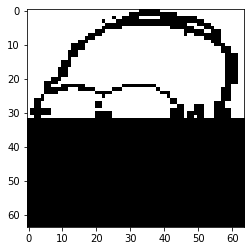

In [92]:
plot_img_vec(initial_state, size)

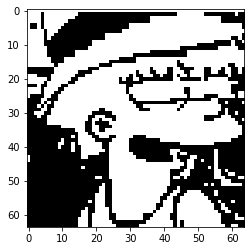

In [93]:
plot_img_vec(final_state, size)

Retrieval is no longer perfect.

In [94]:
W_all = compute_interaction_weights([state_vectors['homer'], state_vectors['homer'], state_vectors['lisa']])

In [95]:
final_state = update_state_from_interactions(initial_state, W_all)

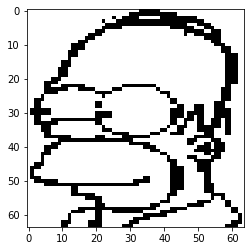

In [96]:
plot_img_vec(final_state, size)

But if we encode the system more heavily with Homer, we still get Homer back.